In [103]:
import numpy as np
import pandas as pd

file_path = (
    "/Users/jeremygoetschy/Projects/Heart_Disease/Raw/heart_cleveland_upload.csv"
)
df = pd.read_csv(file_path)

# Initial Exploration

print(df.shape)
print(f"\n{df.head()}")
print(f"\n{df.info()}")
print(f"\n{df.describe()}")
print(f"\n{df.isna().sum()}")
print(f"\n{df.duplicated().sum()}")

# Small dataset 297/14
# Numerics ["age", "trestbps", "chol", "thalach", "oldpeak"]
# Categorical ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
# Binary problem ["condition"] 1 = disease, 0 = no disease, 46%/54%, mild imbalanced
# Dataset imbalanced by male dominance (67% male, 33% female)
# No missing, no duplicates

(297, 14)

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   69    1   0       160   234    1        2      131      0      0.1      1   
1   69    0   0       140   239    0        0      151      0      1.8      0   
2   66    0   0       150   226    0        0      114      0      2.6      2   
3   65    1   0       138   282    1        2      174      0      1.4      1   
4   64    1   0       110   211    0        2      144      1      1.8      1   

   ca  thal  condition  
0   1     0          0  
1   2     0          0  
2   0     0          0  
3   1     0          1  
4   0     0          0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   ch

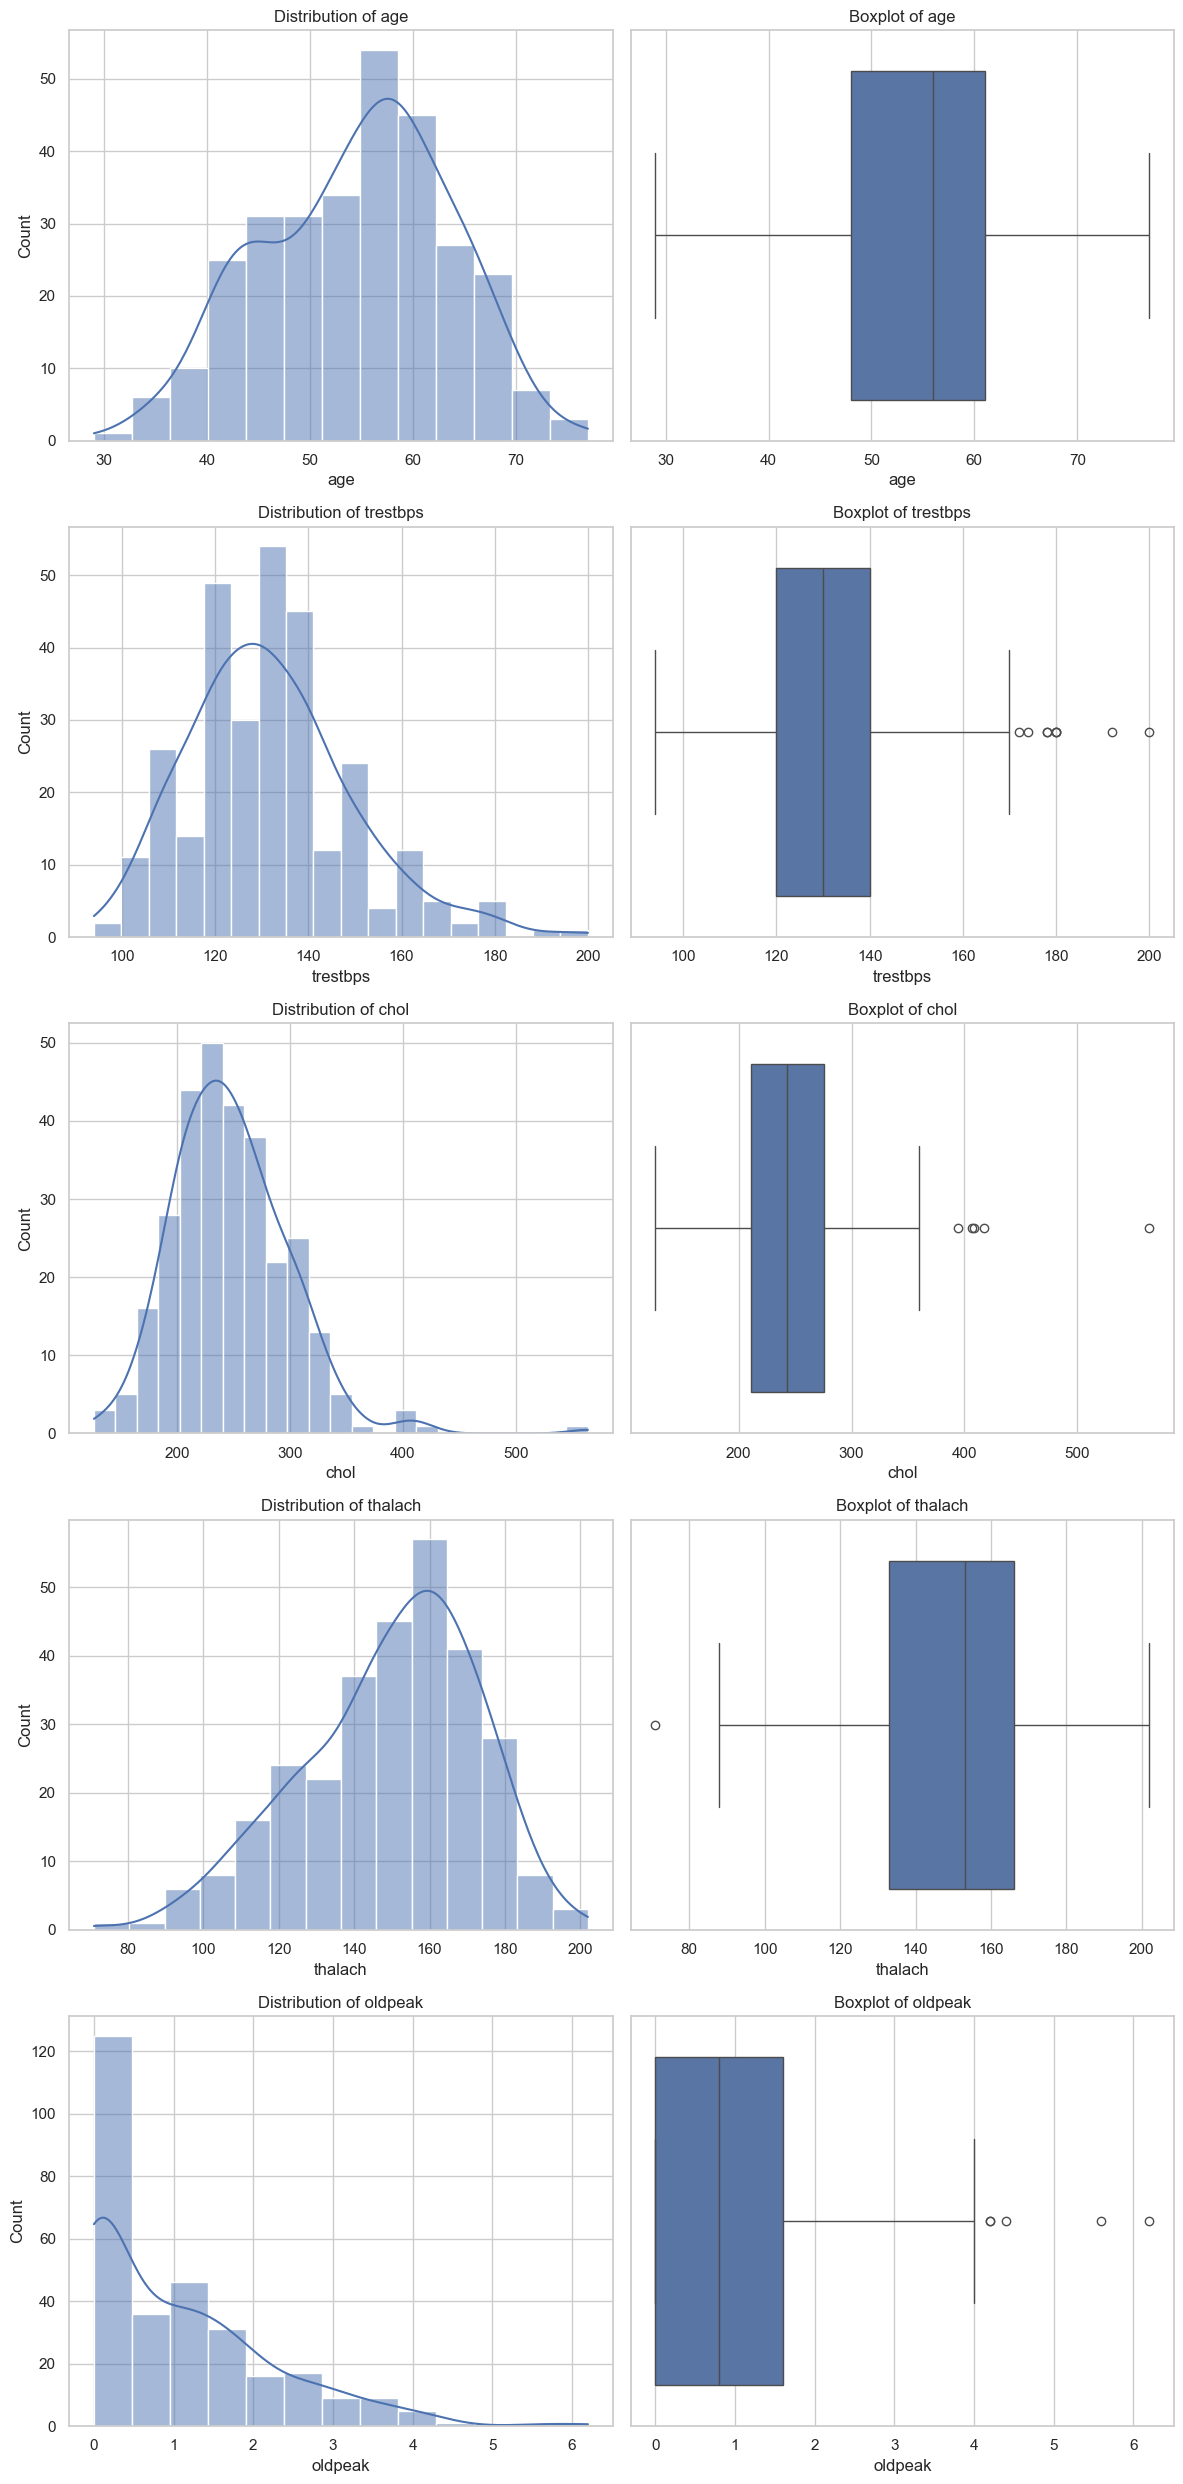

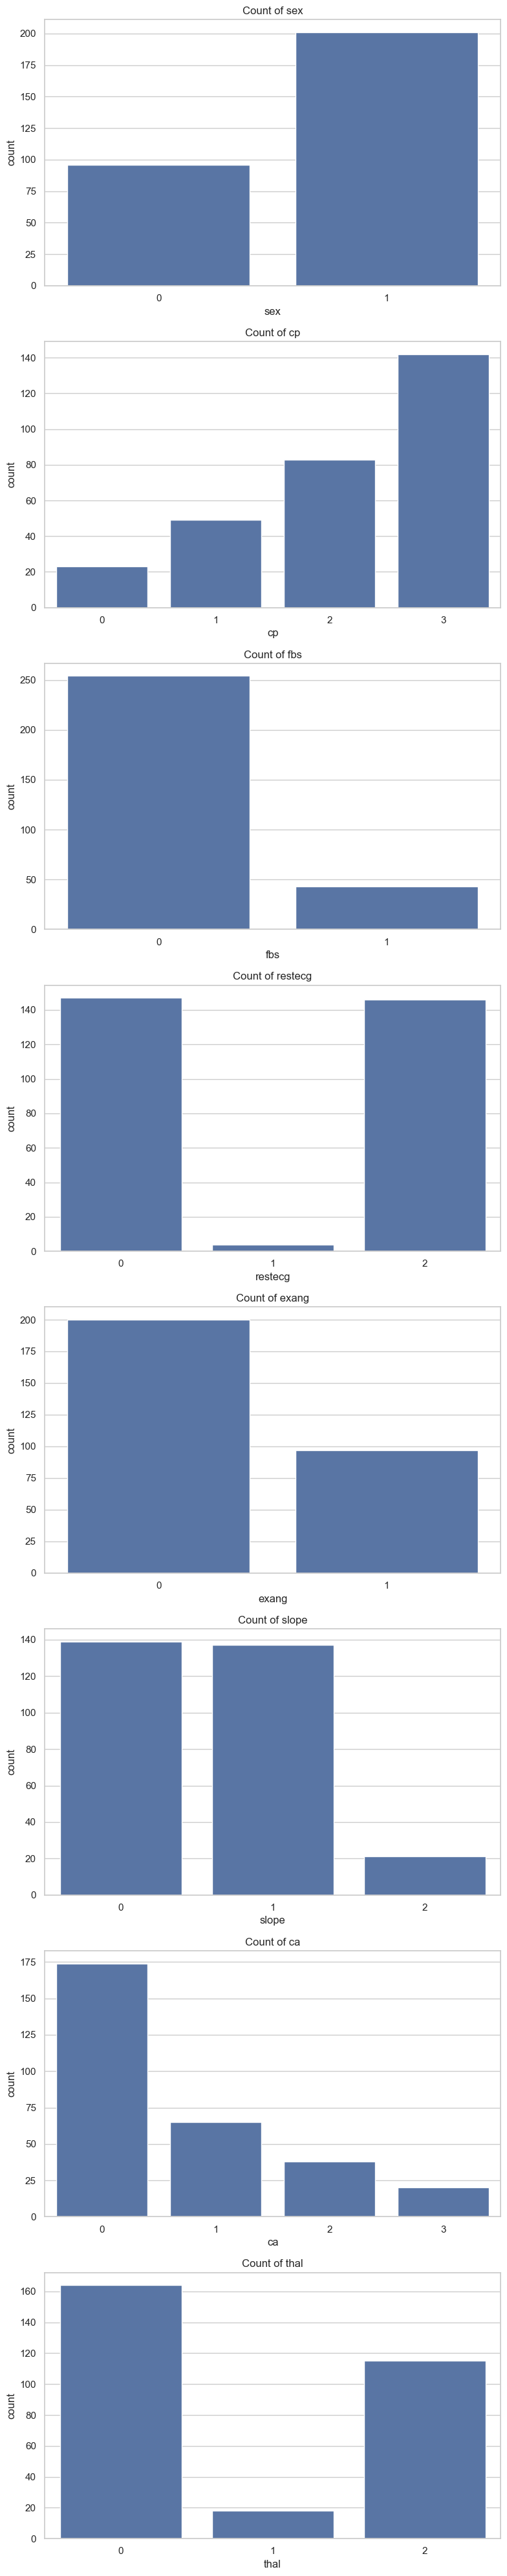

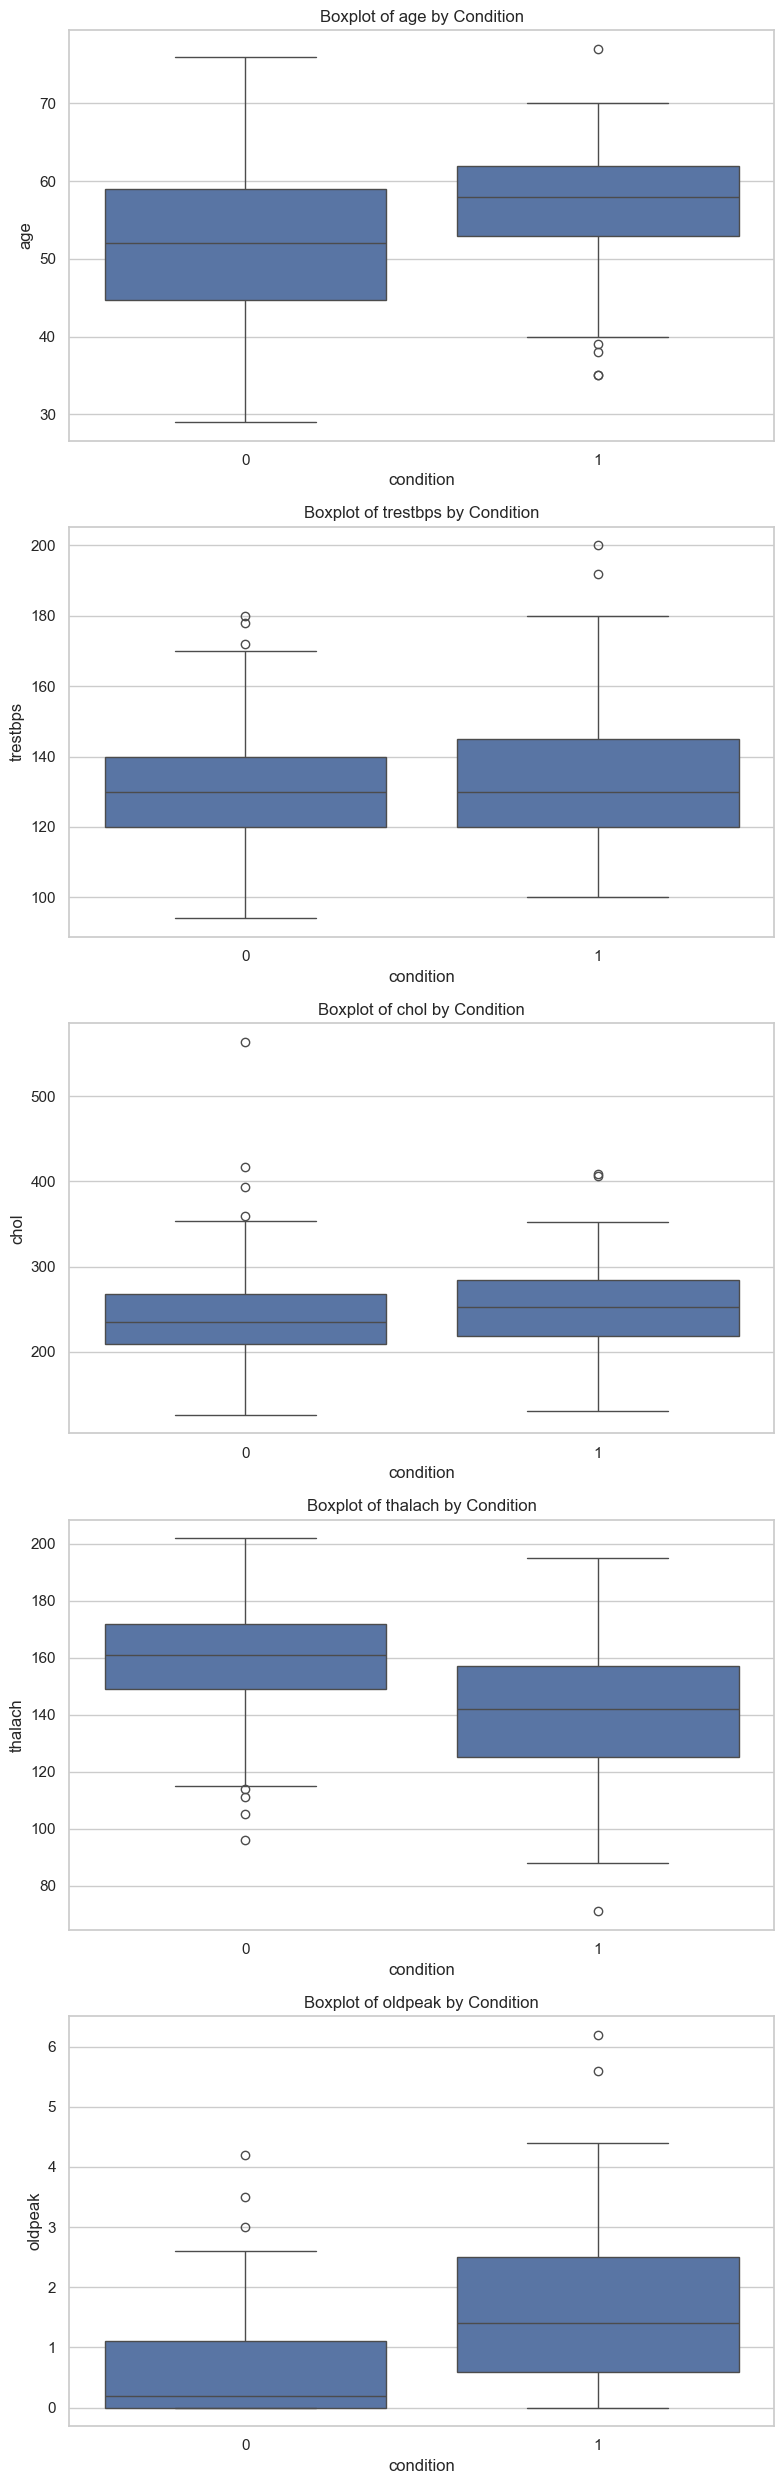

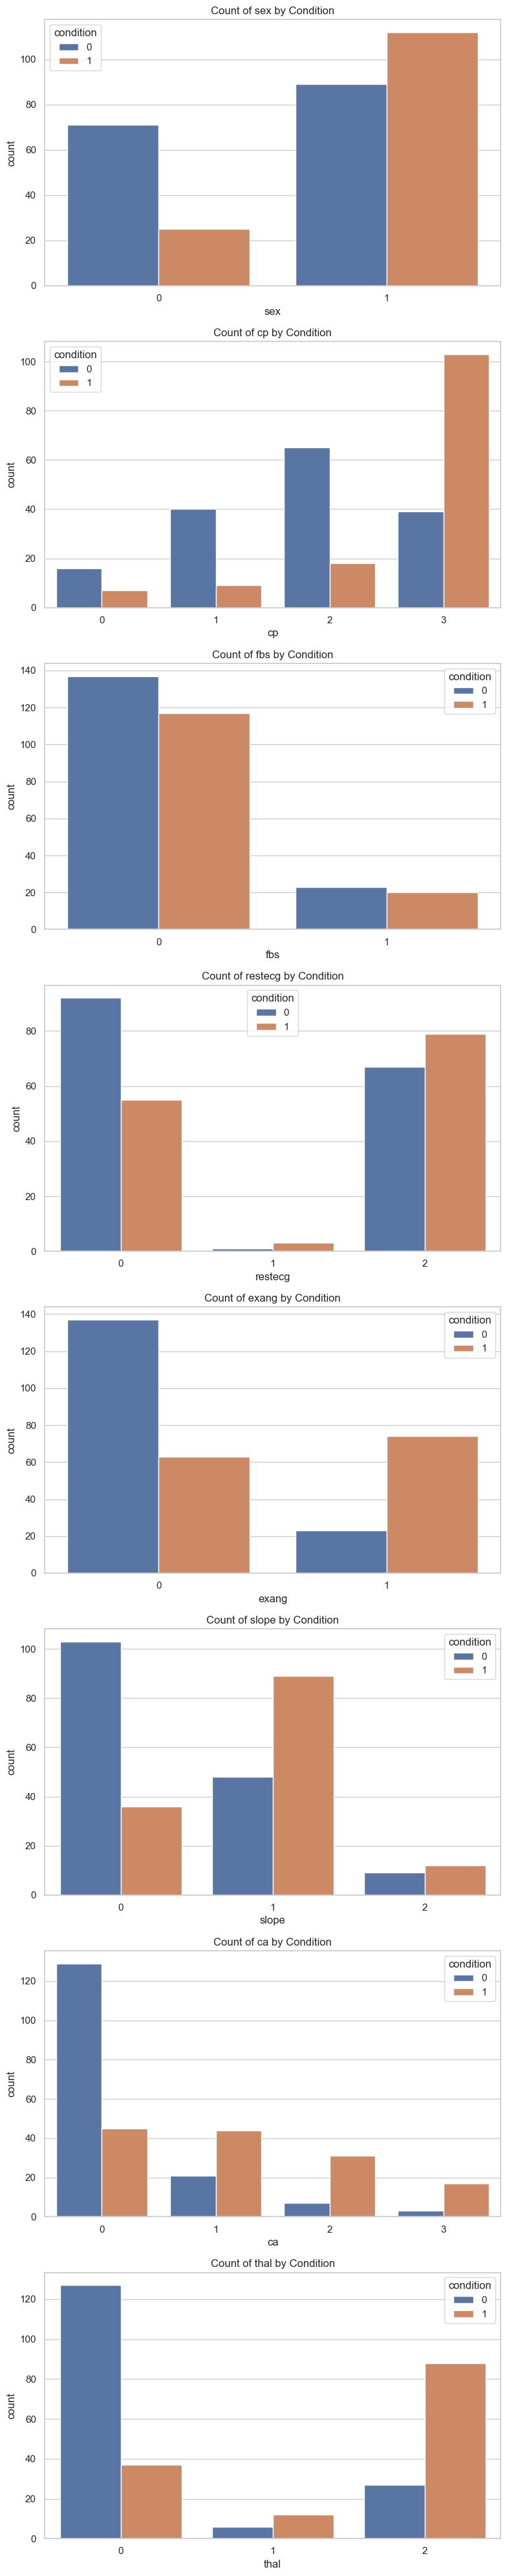

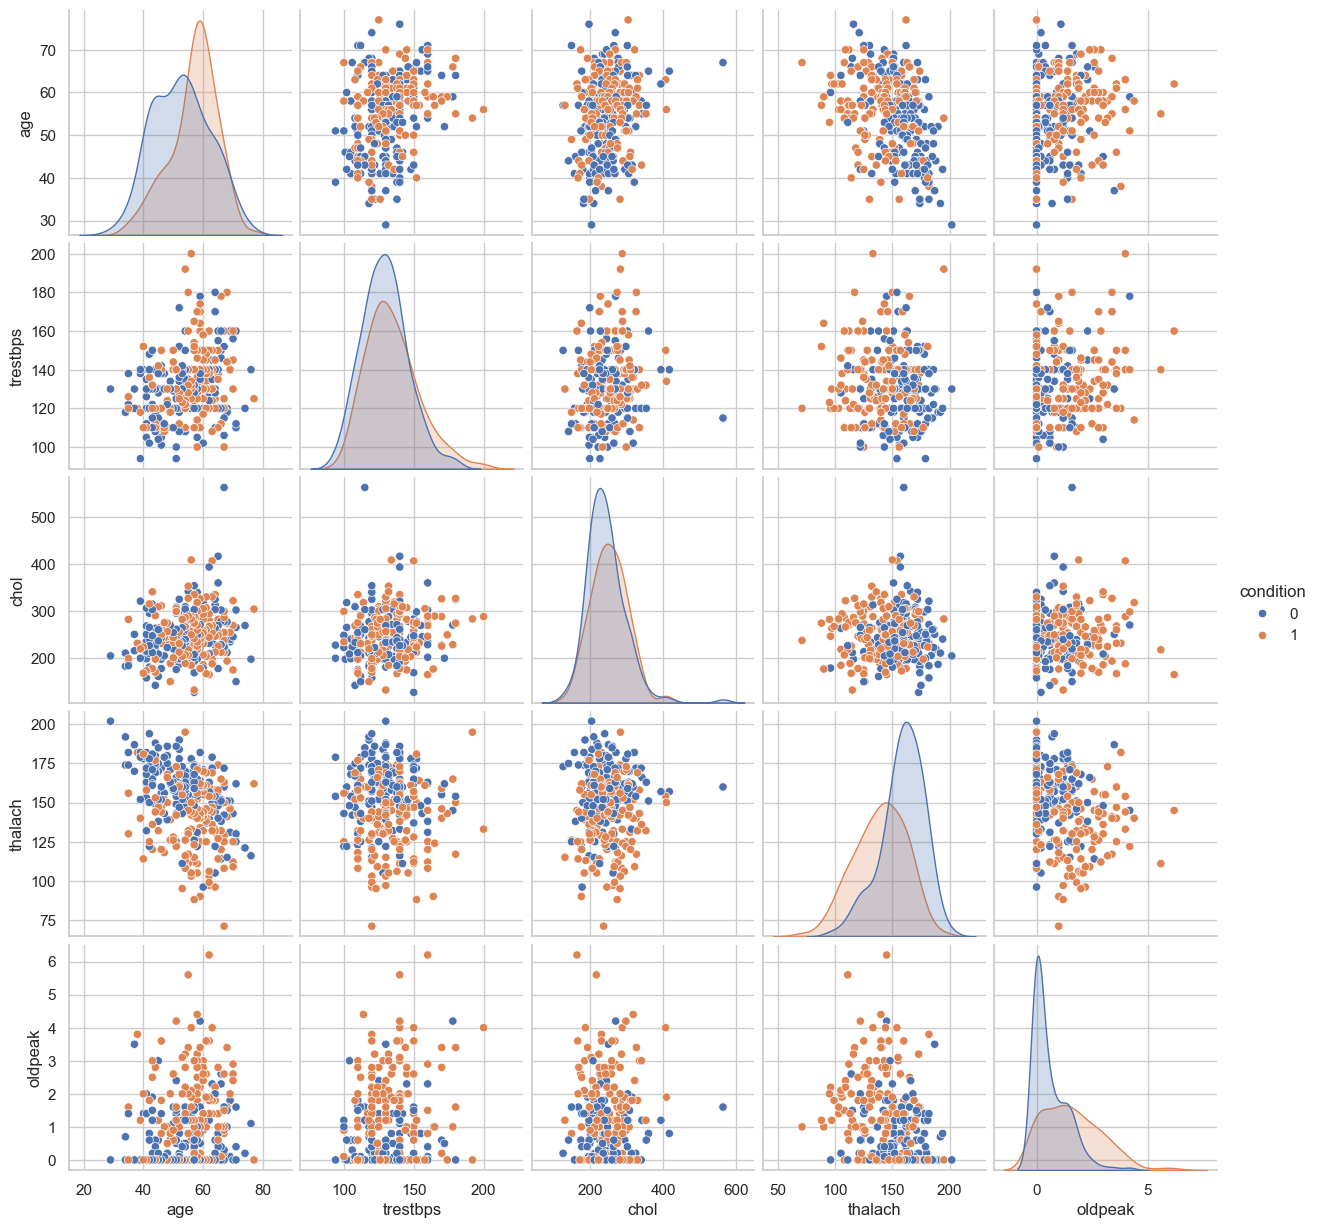

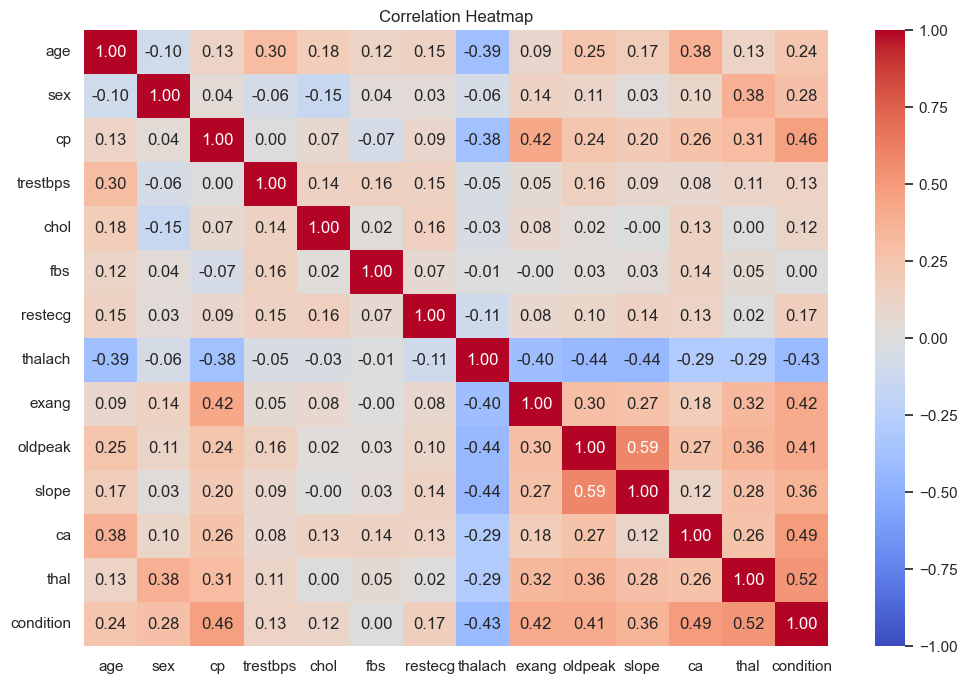

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns

# EDA

sns.set(style="whitegrid")

numerical = ["age", "trestbps", "chol", "thalach", "oldpeak"]
categorical = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]

# Univariate Analysis: Numerical Histogram/Boxplot
fig, axes = plt.subplots(len(numerical), 2, figsize=(12, 5 * len(numerical)))
for i, col in enumerate(numerical):
    sns.histplot(df[col], kde=True, ax=axes[i, 0])
    sns.boxplot(x=df[col], ax=axes[i, 1])
    axes[i, 0].set_title(f"Distribution of {col}")
    axes[i, 1].set_title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()
# Trestbps: Right-skewed, outliers >170
# Chol: Slightly right-skewed, outliers >400
# Thalach: Slightly left-skewed, outliers <80
# Oldpeak: Heavily right-skewed, many zeros, outliers >4

# Univariate Analysis: Categorical Barplot
fig, axes = plt.subplots(len(categorical), 1, figsize=(8, 5 * len(categorical)))
for i, col in enumerate(categorical):
    sns.countplot(x=df[col], ax=axes[i])
    axes[i].set_title(f"Count of {col}")
plt.tight_layout()
plt.show()

# age: imbalanced, more male
# cp: increasing with higher values
# fbs highly imbalanced, 1 is rare
# restecg: 1 is rare
# slope: 2 is rare
# ca: decreasing with higher values
# thal: 1 is rare

# Bivariate Analysis: Numerical vs Target (Boxplot)
fig, axes = plt.subplots(len(numerical), 1, figsize=(8, 5 * len(numerical)))
for i, col in enumerate(numerical):
    sns.boxplot(x=df["condition"], y=df[col], ax=axes[i])
    axes[i].set_title(f"Boxplot of {col} by Condition")
plt.tight_layout()
plt.show()

# age: condition 1 slightly higher 60 vs 53
# thalach: condition 1 significantly lower 140 vs 160 for no disease
# oldpeak: condition 1 higher +1

# Bivariate Analysis: Categorical vs Target (Countplot)
fig, axes = plt.subplots(len(categorical), 1, figsize=(8, 5 * len(categorical)))
for i, col in enumerate(categorical):
    sns.countplot(x=df[col], hue=df["condition"], ax=axes[i])
    axes[i].set_title(f"Count of {col} by Condition")
plt.tight_layout()
plt.show()

# sex: more male in condition 1
# cp: 3 is highly correlated with condition 1
# restecg: 2 is correlated with condition 1
# exang: 1 is correlated with condition 1
# slope: 1 is correlated with disease
# ca: higher values decreased the proportion of no disease
# thal: 2 is highly correlated with condition 1

# Multivariate Analysis: Pairplot
sns.pairplot(df, hue="condition", vars=numerical)
plt.show()

# Overlaps in most pairs; no single feature perfectly separates classes.

# Heatmap Spearman (non linear)
plt.figure(figsize=(12, 8))
sns.heatmap(
    df.corr(method="spearman"),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
)
plt.title("Correlation Heatmap")
plt.show()
# Target correlation
# thal (0.52) - ca (0.49) - cp (0.46) - thalach (-0.43)

# Multi collinearity
# oldpeak + slope (0.59)
# thalach + slope + oldpeak + exang (-0.40 -0.44)

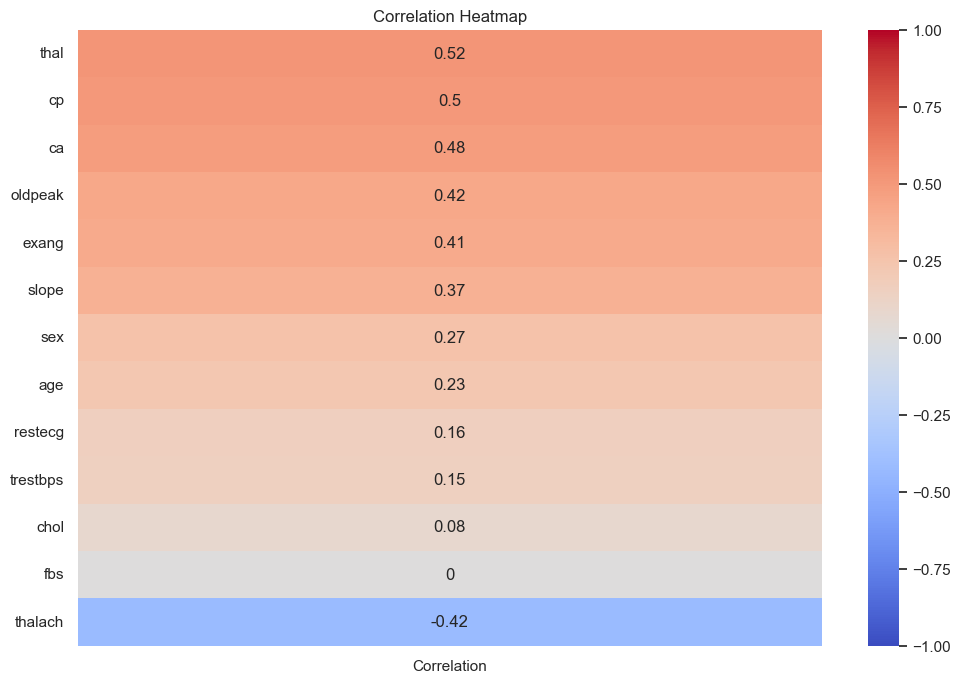

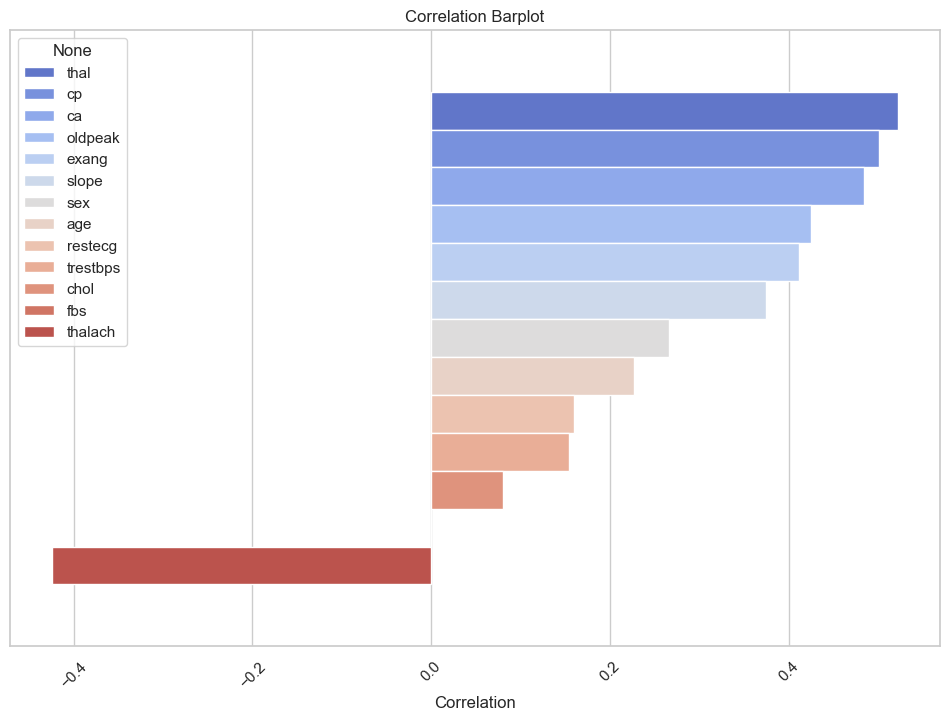

In [105]:
from scipy.stats import pointbiserialr, chi2_contingency

# Heatmap: Fonction Cramér's V + pointbiserialr

# pointbiserialr: corr between numerics & binary (condition)
# Cramér’s V: corr between categoricals & condition


def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))


correlations = {}

# Point Biserial Correlation
for col in numerical:
    correlations[col] = pointbiserialr(df[col], df["condition"])[0]

# Cramér's V
for col in categorical:
    correlations[col] = cramers_v(df[col], df["condition"])

# Visualization
corr_df = pd.DataFrame.from_dict(correlations, orient="index", columns=["Correlation"])
corr_df = corr_df.sort_values(by="Correlation", ascending=False)
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_df,
    annot=True,
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
)
plt.title("Correlation Heatmap")
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(
    x=corr_df["Correlation"], hue=corr_df.index, palette="coolwarm", data=corr_df
)
plt.title("Correlation Barplot")
plt.xticks(rotation=45)
plt.show()

# Confirmation key predictors
# thal, ca, cp and thalach

In [106]:
# Feature Engineering

# Log Transformation
df["oldpeak_log"] = np.log1p(df["oldpeak"])

# Try to enhance correlation of trestbps
df["trestbps_age"] = df["trestbps"] * df["age"]

# Combine two features more correlated
df["stress_score"] = df["oldpeak_log"] * df["slope"]

In [107]:
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer

numerical = [
    "age",
    "thalach",
    "trestbps",
    "oldpeak_log",
    "trestbps_age",
    "stress_score",
]
categorical = ["sex", "cp", "restecg", "exang", "ca", "thal", "slope"]

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), numerical),
        ("cat", OneHotEncoder(drop="first", sparse_output=False), categorical),
    ]
)

X = df.drop(columns=["condition"], axis=1)
y = df["condition"]
X_preprocessed = preprocessor.fit_transform(X)

# Get feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=feature_names)

# Cleaning preprocess
X_preprocessed_df.columns = [
    col.replace("cat__", "").replace("num__", "") for col in X_preprocessed_df.columns
]

print(X_preprocessed.shape)  # 297/20
print(f"\n{X_preprocessed_df.head()}")


# Feature engineering after baseline
# Robustscaler to handle skew

(297, 20)

        age   thalach  trestbps  oldpeak_log  trestbps_age  stress_score  \
0  1.000000 -0.666667       1.5    -0.515406      1.547619      0.099748   
1  1.000000 -0.060606       0.5     0.462404      1.000000      0.000000   
2  0.769231 -1.181818       1.0     0.725420      1.095238      2.681148   
3  0.692308  0.636364       0.4     0.301077      0.726190      0.916231   
4  0.615385 -0.272727      -1.0     0.462404     -0.039683      1.077558   

   sex_1  cp_1  cp_2  cp_3  restecg_1  restecg_2  exang_1  ca_1  ca_2  ca_3  \
0    1.0   0.0   0.0   0.0        0.0        1.0      0.0   1.0   0.0   0.0   
1    0.0   0.0   0.0   0.0        0.0        0.0      0.0   0.0   1.0   0.0   
2    0.0   0.0   0.0   0.0        0.0        0.0      0.0   0.0   0.0   0.0   
3    1.0   0.0   0.0   0.0        0.0        1.0      0.0   1.0   0.0   0.0   
4    1.0   0.0   0.0   0.0        0.0        1.0      1.0   0.0   0.0   0.0   

   thal_1  thal_2  slope_1  slope_2  
0     0.0     0.0  

In [110]:
# Baseline LR

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

model = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42, class_weight="balanced"),
    "XGBoost": XGBClassifier(
        use_label_encoder=False, eval_metric="logloss", random_state=42
    ),
    "LightGBM": LGBMClassifier(random_state=42),
    "SVC": SVC(probability=True, random_state=42),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"roc_auc": "roc_auc", "average_precision": "average_precision", "f1": "f1"}

results = {}

for model_name, model in model.items():
    pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model)])

    scores = cross_validate(
        pipeline, X, y, cv=cv, scoring=scoring, return_train_score=False
    )

    results[model_name] = {
        "roc_auc": np.mean(scores["test_roc_auc"]),
        "average_precision": np.mean(scores["test_average_precision"]),
        "f1": np.mean(scores["test_f1"]),
    }

df_results = pd.DataFrame(results).T
print(df_results)

/opt/homebrew/Caskroom/miniconda/base/envs/ds_elite/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:07:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Caskroom/miniconda/base/envs/ds_elite/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:07:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Caskroom/miniconda/base/envs/ds_elite/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:07:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Caskroom/miniconda/base/envs/ds_elite/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:07:06] 

[LightGBM] [Info] Number of positive: 109, number of negative: 128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 267
[LightGBM] [Info] Number of data points in the train set: 237, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.459916 -> initscore=-0.160682
[LightGBM] [Info] Start training from score -0.160682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/opt/homebrew/Caskroom/miniconda/base/envs/ds_elite/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ds_elite/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ds_elite/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ds_elite/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/envs/ds_elite/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ds_elite/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ds_elite/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ds_elite/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/envs/ds_elite/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ds_elite/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[I 2025-08-28 15:03:57,722] A new study created in memory with name: no-name-fdcde23f-8881-420d-a88d-2625f52d6667
[I 2025-08-28 15:03:57,770] Trial 0 finished with value: 0.8689732142857143 and parameters: {'C': 7.834243466032855e-05, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.8689732142857143.
[I 2025-08-28 15:03:57,815] Trial 1 finished with value: 0.8758928571428571 and parameters: {'C': 0.004414086601427148, 'solver': 'saga'}. Best is trial 1 with value: 0.8758928571428571.
[I 2025-08-28 15:03:57,945] Trial 2 finished with value: 0.9125744047619048 and parameters: {'C': 25.964965189833883, 'solver': 'saga'}. Best is trial 2 with value: 0.9125744047619048.
[I 2025-08-28 15:03:58,001] Trial 3 finished with value: 0.8761160714285714 and parameters: {'C': 0.00488811148420883, 'solver': 'saga'}. Best is trial 2 with value: 0.9125744047619048.
[I 2025-08-28 15:03:58,051] Trial 4 finished with value: 0.9172619047619047 and parameters: {'C': 0.7056640919682237, 'solver': 'newton-cg'

Best hyperparameters:  {'C': 0.8783454719356759, 'solver': 'lbfgs'}
Best ROC AUC:  0.9193287037037038

Results :
ROC AUC:  0.9754464285714286
Average Precision:  0.9792386520275389
F1 Score:  0.9019607843137255


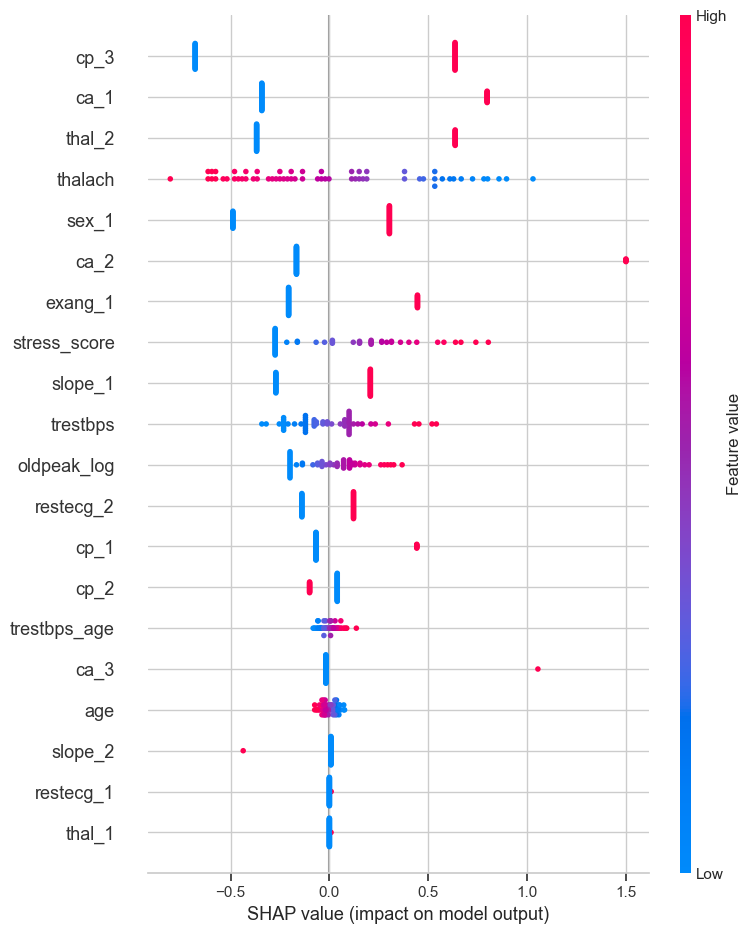

In [ ]:
import optuna
import shap


# Hyperparameters
def objective(trial):
    C = trial.suggest_float("C", 1e-5, 1e2, log=True)
    solver = trial.suggest_categorical("solver", ["lbfgs", "newton-cg", "saga"])

    model = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            (
                "classifier",
                LogisticRegression(
                    C=C, penalty="l2", solver=solver, max_iter=2000, random_state=42
                ),
            ),
        ]
    )
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_validate(
        model, X, y, cv=cv, scoring="roc_auc", return_train_score=False
    )
    return np.mean(scores["test_score"])


# Run Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best hyperparameters: ", study.best_params)
print("Best ROC AUC: ", study.best_value)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

best_params = study.best_params
final_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            LogisticRegression(**best_params, max_iter=1000, random_state=42),
        ),
    ]
)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

print(f"\nResults :")
print("ROC AUC: ", roc_auc_score(y_test, y_proba))
print("Average Precision: ", average_precision_score(y_test, y_proba))
print("F1 Score: ", f1_score(y_test, y_pred))

# Shap
X_test_preprocessed = final_model.named_steps["preprocessor"].transform(X_test)
explainer = shap.Explainer(
    final_model.named_steps["classifier"],
    X_test_preprocessed,
)
shap_values = explainer(X_test_preprocessed)

shap.summary_plot(
    shap_values,
    features=X_test_preprocessed,
    feature_names=X_preprocessed_df.columns,
)

# Baseline Results
#                     roc_auc     average_precision f1
# LogisticRegression  0.913872       0.912719    0.826444
# RandomForest        0.885966       0.879849    0.757590
# XGBoost             0.856771       0.858759    0.754671

# LR + optuna
# Best ROC AUC:  0.9154348544973544


# Results with log and feature engineering
#                     roc_auc  average_precision        f1
# LogisticRegression  0.918419           0.918131  0.819824
# RandomForest        0.884747           0.883382  0.796050
# XGBoost             0.869750           0.870647  0.773433
# LightGBM            0.884838           0.882352  0.770708
# SVC                 0.900008           0.894637  0.813224

# Final model results:
# Best ROC AUC:  0.9193287037037038 #training
# ROC AUC:  0.9765625 # test set
# Average Precision:  0.9797923618835742
# F1 Score:  0.9019607843137255


# After evaluating multiple models, Logistic Regression emerged as
# the best-performing approach, achieving a ROC AUC of 0.919, with
# strong F1 and average precision scores. Feature engineering, including
# the creation of oldpeak_log, stress_score, and trestbps_age, remove fbs
# and chol improved predictive performance while keeping the model interpretable.

# SHAP analysis confirmed that key clinical features as we have seen during EDA, are:
# chest pain type (cp),
# number of major vessels (ca)
# thalassemia (thal)
# stress_score (oldpeak + slope)
# and maximum heart rate achieved (thalach)
# play the most significant roles in prediction.


# Deployment

import joblib

# Save
joblib.dump(final_model, "heart_disease_model.pkl")

# Load
loaded_model = joblib.load("heart_disease_model.pkl")
preds = loaded_model.predict(X)